<a href="https://colab.research.google.com/github/Jaimemorillo/covid-assignment/blob/main/survival_cox_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_path = '/content/gdrive/MyDrive/covid_assignment/COVID19_data.csv'

In [ ]:
%pip install lifelines

     |████████████████████████████████| 348 kB 5.1 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=a356386cd45c6ab86a3d985733b0ae8cdee4cf4ed02f50ec6798bfc672214a78
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

## Preprocessing

In [ ]:
df = pd.read_csv(
    data_path,
    sep=',', 
    header='infer',
    index_col = "ID"
)
# remove DESTIONATION column
df.pop("DESTINATION")

# fetch categorical columns before doing any other preprocessing
cat_mask = (df.dtypes == object)
cat_cols= df.columns[cat_mask].tolist()

# remove all rows containing NA values (47 of them)
df = df.dropna()

# drop all rows where the important values are all 0
df.drop(df[(df["TEMP"] == 0) & (df["HEART_RATE"] == 0) &  (df["GLUCOSE"] == 0) & ( df["SAT_O2"] == 0) & (df["BLOOD_PRES_SYS"] == 0) & (df["BLOOD_PRES_DIAS"] == 0)].index)

# only remove the very big outliers, the smaller ones might be relevant
df = df.drop(df[(df["HEART_RATE"] > 400)].index)
df = df.drop(df[(df["BLOOD_PRES_SYS"] > 600)].index)
df = df.drop(df[(df["BLOOD_PRES_DIAS"] > 400)].index)
df = df.drop(df[(df["AGE"] > 180)].index)

# create 2 separate dataframes, categorical and numerical
df_cat = df[cat_cols]
df_num = df.drop(cat_cols, axis = 1)
# does a bit encoding for SEX and EXITUS
d = defaultdict(preprocessing.LabelEncoder)
df_cat_le = df_cat.apply(lambda col: d[col.name].fit_transform(col))

df = pd.merge(left = df_cat_le, right = df_num, on = "ID")


In [ ]:
df.loc[:,'DIE'] = df['EXITUS'].apply(lambda x: 1 if x==0 else 0)
df = df.drop(['EXITUS'], axis=1)

df.loc[:,'DAYS_TOTAL'] = df.DAYS_HOSPITAL + df.DAYS_ICU

In [ ]:
df

,SEX,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS,DIE,DAYS_TOTAL
ID,,,,,,,,,,,,
1,0,15.0,4,0,37.0,0,0,92,0,0,1,4
2,0,18.0,4,0,37.3,105,0,97,0,0,1,4
3,1,21.0,7,0,38.5,112,0,95,85,47,1,7
4,1,21.0,10,0,39.2,113,0,97,0,0,1,10
5,1,22.0,4,0,36.3,80,0,92,111,70,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2045,1,100.0,2,0,36.6,65,0,84,144,80,0,2
2046,0,101.0,2,0,36.8,84,0,95,110,65,0,2
2047,0,102.0,5,0,36.5,83,0,94,150,65,0,5


In [ ]:
df.DIE.value_counts(normalize=True)

1    0.835664
0    0.164336
Name: DIE, dtype: float64

## Slipt train and test (test 20%)

Stardscaler is applied

In [ ]:
X = df.drop(['DIE'], axis=1)
y = df['DIE'].values

# Scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

print('Size train: ' + str(len(X_train)))
print('Size test: ' + str(len(X_test)))

Size train: 1601
Size test: 401


In [ ]:
## Check if it is the same
train, test = train_test_split(df.drop(['DAYS_HOSPITAL', 'DAYS_ICU'], axis=1), 
                               test_size=0.2, random_state=9, stratify=df['DIE'])

## Grid search and cross-validation

5-fold

In [ ]:
cph = CoxPHFitter()
cph.fit(train, duration_col='DAYS_TOTAL', event_col='DIE', show_progress=True)

Iteration 1: norm_delta = 0.54057, step_size = 0.9000, log_lik = -8567.59423, newton_decrement = 69.31832, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.08432, step_size = 0.9000, log_lik = -8498.14416, newton_decrement = 1.17482, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00920, step_size = 0.9000, log_lik = -8496.97636, newton_decrement = 0.01361, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, log_lik = -8496.96275, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1601 total observations, 263 right-censored observations>

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1601 total observations, 263 right-censored observations>
             duration col = 'DAYS_TOTAL'
                event col = 'DIE'
      baseline estimation = breslow
   number of observations = 1601
number of events observed = 1338
   partial log-likelihood = -8496.96
         time fit was run = 2022-01-08 13:26:45 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
SEX              -0.26       0.77       0.06            -0.37            -0.15                 0.69                 0.86
AGE              -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
TEMP              0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
HEART_RATE       -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
GLUCOSE          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SAT_O2            0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
BLOOD_PRES_SYS    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
BLOOD_PRES_DIAS  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00

                    z      p   -log2(p)
covariate                              
SEX             -4.64 <0.005      18.13
AGE             -9.22 <0.005      64.91
TEMP             0.36   0.72       0.48
HEART_RATE      -4.84 <0.005      19.55
GLUCOSE         -0.09   0.93       0.11
SAT_O2           5.92 <0.005      28.19
BLOOD_PRES_SYS   0.16   0.88       0.19
BLOOD_PRES_DIAS -0.54   0.59       0.77
---
Concordance = 0.60
Partial AIC = 17009.93
log-likelihood ratio test = 141.26 on 8 df
-log2(p) of ll-ratio test = 86.00

In [ ]:
print(cph.log_likelihood_)
print(cph.score(test))

-8496.96274542084
-4.171350167486245


In [ ]:
cph.predict_median(test)

885     10.0
2006     9.0
845      7.0
1594     7.0
698      8.0
        ... 
1496     6.0
1982    10.0
960      8.0
622      7.0
1970     9.0
Name: 0.5, Length: 401, dtype: float64

In [103]:
parameters = {
   "penalizer": 10.0 ** np.arange(-2, 3),
   "l1_ratio": [0, 1/3, 2/3],
   "model_ancillary": [True, False],
}

CoxRegression = sklearn_adapter(CoxPHFitter)
# CoxRegression is a class like the `LinearRegression` class or `SVC` class in scikit-learn
sk_cph = CoxRegression(penalizer=1e-5, duration_col='DAYS_TOTAL')
clf = GridSearchCV(sk_cph, parameters, cv=5)
clf.fit(pd.DataFrame(X_train), y_train)

GridSearchCV(cv=5,
             estimator=SkLearnCoxPHFitter(baseline_estimation_method='breslow',
                                          breakpoints=None, knots=None,
                                          l1_ratio=0.0, n_baseline_knots=None,
                                          penalizer=1e-05, strata=None),
             param_grid={'l1_ratio': [0, 0.3333333333333333,
                                      0.6666666666666666],
                         'model_ancillary': [True, False],
                         'penalizer': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])})

## Results

### Best params

In [104]:
print(clf.best_params_) #Best parameters selected
print(clf.best_estimator_) #Best estimator
pd.DataFrame(clf.cv_results_) # Dataframe with every train

{'l1_ratio': 0.3333333333333333, 'model_ancillary': True, 'penalizer': 0.01}
SkLearnCoxPHFitter(baseline_estimation_method='breslow', breakpoints=None,
                   knots=None, l1_ratio=0.3333333333333333,
                   n_baseline_knots=None, penalizer=0.01, strata=None)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l1_ratio,param_model_ancillary,param_penalizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098688,0.002201,0.017820,0.000452,0,True,0.01,"{'l1_ratio': 0, 'model_ancillary': True, 'pena...",0.746740,0.828623,0.817290,0.830459,0.877030,0.820028,0.041977,7
1,0.098502,0.002246,0.019974,0.002983,0,True,0.1,"{'l1_ratio': 0, 'model_ancillary': True, 'pena...",0.746185,0.829159,0.822093,0.831744,0.872204,0.820277,0.040987,5
2,0.094481,0.002739,0.018333,0.001572,0,True,1,"{'l1_ratio': 0, 'model_ancillary': True, 'pena...",0.751803,0.825789,0.825829,0.818351,0.840954,0.812545,0.031248,11
3,0.098885,0.003718,0.017577,0.000193,0,True,10,"{'l1_ratio': 0, 'model_ancillary': True, 'pena...",0.760681,0.816215,0.822360,0.792850,0.769646,0.792350,0.024449,15
4,0.102163,0.009416,0.018602,0.001866,0,True,100,"{'l1_ratio': 0, 'model_ancillary': True, 'pena...",0.761444,0.811466,0.820225,0.783584,0.737477,0.782839,0.030768,19
5,0.106812,0.013032,0.017910,0.000613,0,False,0.01,"{'l1_ratio': 0, 'model_ancillary': False, 'pen...",0.746740,0.828623,0.817290,0.830459,0.877030,0.820028,0.041977,7
6,0.102614,0.005452,0.018019,0.000391,0,False,0.1,"{'l1_ratio': 0, 'model_ancillary': False, 'pen...",0.746185,0.829159,0.822093,0.831744,0.872204,0.820277,0.040987,5
7,0.101999,0.003219,0.017727,0.000185,0,False,1,"{'l1_ratio': 0, 'model_ancillary': False, 'pen...",0.751803,0.825789,0.825829,0.818351,0.840954,0.812545,0.031248,11
8,0.105719,0.007885,0.018875,0.000572,0,False,10,"{'l1_ratio': 0, 'model_ancillary': False, 'pen...",0.760681,0.816215,0.822360,0.792850,0.769646,0.792350,0.024449,15
9,0.108853,0.006751,0.018966,0.000702,0,False,100,"{'l1_ratio': 0, 'model_ancillary': False, 'pen...",0.761444,0.811466,0.820225,0.783584,0.737477,0.782839,0.030768,19


### Final metrics (test)

AUC: 0.892
Acc: 0.875
Conf. Matrix: 
[[ 24  42]
 [  8 327]]


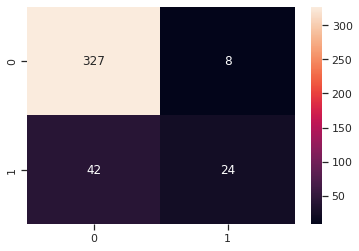

In [106]:
y_pred_prob = clf.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
print('AUC: ' + str(roc_auc_score(y_test, y_pred_prob).round(3)))

def plot_metrics(y_test, y_pred):
  print('Acc: ' + str(accuracy_score(y_test, y_pred).round(3)))
  #print('Precision: ' + str(precision_score(y_test, y_pred).round(3)))
  #print('Recall: ' + str(recall_score(y_test, y_pred).round(3)))
  #print('F1: ' + str(f1_score(y_test, y_pred).round(3)))
  print('Conf. Matrix: ')
  print(confusion_matrix(y_test, y_pred))
  sns.heatmap([[327,8],[42,24]], annot=True, fmt='g')

  return None

plot_metrics(y_test,y_pred)